<a href="https://colab.research.google.com/github/JohanMonster/MyRepos/blob/master/ML_Competition_hyperopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from hyperopt import hp,fmin,Trials,tpe,STATUS_OK
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample

In [0]:
data=pd.read_csv('/train_file.csv')

In [0]:
targets=data.Greater_Risk_Probability
z=data.drop(['Patient_ID','LocationDesc','Greater_Risk_Question','Description','GeoLocation','QuestionCode','Greater_Risk_Probability'],axis=1)

In [0]:
z.columns

Index(['YEAR', 'Subtopic', 'Sample_Size', 'Sex', 'Race', 'Grade', 'StratID1',
       'StratID2', 'StratID3', 'StratificationType',
       'Greater_Risk_Probability'],
      dtype='object')

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.linear_model import Lasso,ElasticNet
import xgboost
import lightgbm
import hyperopt
from mlxtend.regressor import StackingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold

In [0]:
le=LabelEncoder()
z['Sex']=le.fit_transform(z['Sex'])
z['Race']=le.fit_transform(z['Race'])
z.StratificationType=le.fit_transform(z.StratificationType)

In [0]:
kfold=KFold(n_splits=10,shuffle=True)
?RandomForestRegressor

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(z,targets,test_size=0.2)

In [0]:
def objective_fn(space):
  rfr_h=RandomForestRegressor(n_estimators=space['n_estimators'],max_depth=space['max_depth'],
                              min_samples_split=space['min_samples_split'],
                              bootstrap=space['bootstrap'],max_features=space['max_features'])
  rfr_h.fit(X_train,y_train)
  return {'loss':mean_squared_error(y_test,rfr_h.predict(X_test)),'status':STATUS_OK}
  
  

In [0]:
space = {
        'max_depth': hp.quniform("max_depth", 1, 20, 1),
         'n_estimators':scope.int(hp.quniform('n_estimators',100,1000,50)),
          'min_samples_split':scope.int(hp.quniform('min_samples_split',2,30,1)),
          'bootstrap':hp.choice('bootstrap',['True','False']),
        'max_features':hp.choice('max_features',['auto','sqrt','log2'])
       }

In [34]:
type(sample(space)['n_estimators'])

int

In [37]:
trials = Trials()
best = fmin(fn=objective_fn,
                     space=space,
                     algo=tpe.suggest,
                     max_evals=250,
                     trials=trials
                     )

100%|██████████| 250/250 [1:27:06<00:00, 32.63s/it, best loss: 239.89167946094088]


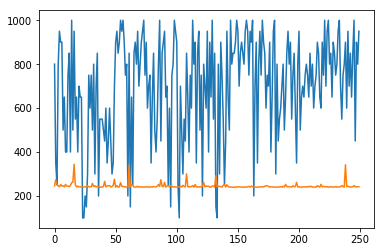

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
z=[]
scores=[]
for i in range(250):
  z.append(trials.trials[i]['misc']['vals']['n_estimators'])
  scores.append(trials.results[i]['loss'])

z=np.asarray(z)
scores=pd.DataFrame(np.asarray(scores),index=range(250))
scores=pd.DataFrame(np.reshape(scores,newshape=(250,1)),index=range(250))
plt.plot(z)
plt.plot(scores)
  


In [82]:
trials.best_trial

{'book_time': datetime.datetime(2019, 4, 21, 11, 56, 55, 826000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'bootstrap': [182],
   'max_depth': [182],
   'max_features': [182],
   'min_samples_split': [182],
   'n_estimators': [182]},
  'tid': 182,
  'vals': {'bootstrap': [1],
   'max_depth': [10.0],
   'max_features': [1],
   'min_samples_split': [26.0],
   'n_estimators': [800.0]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2019, 4, 21, 11, 57, 14, 839000),
 'result': {'loss': 239.89167946094088, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 182,
 'version': 0}

In [0]:
rfr=RandomForestRegressor(n_estimators=500,max_depth=6,n_jobs=-1)
exr=ExtraTreesRegressor(n_estimators=400,max_depth=4,n_jobs=-1)
en=ElasticNet()
lasso=Lasso()
light=lightgbm.LGBMRegressor(learning_rate=0.01,n_estimators=9999,reg_alpha=0.4,reg_lambda=0.2)
xgb=xgboost.XGBRegressor(learning_rate=0.01,n_estimators=9999,reg_alpha=0.3,reg_lambda=0.234)

In [0]:
for i,(train,val) in enumerate(kfold.split(z.values,targets.values)):
  print("Fold:",i)
  train_data,train_labels=z.iloc[train],targets.iloc[train]
  val_data,val_labels=z.iloc[val],targets.iloc[val]
  rfr.fit(train_data,train_labels)
  exr.fit(train_data,train_labels)
  en.fit(train_data,train_labels)
  lasso.fit(train_data,train_labels)
  light.fit(train_data,train_labels,early_stopping_rounds=300,eval_metric='mse',eval_set=(val_data,val_labels))
  stacking_reg=StackingRegressor(regressors=[rfr,exr,en,lasso,light],meta_regressor=light)
  stacking_reg.fit(train_data,train_labels)
  #xgb.fit(train_data,train_labels,early_stopping_rounds=100,eval_set=(val_data,val_labels))
  rfr_pred=rfr.predict(val_data)
  exr_pred=exr.predict(val_data)
  en_pred=en.predict(val_data)
  lasso_pred=lasso.predict(val_data)
  light_pred=light.predict(val_data)
  #xgb_pred=xgb.predict(val_data)
  stacking_pred=stacking_reg.predict(val_data)
  ensemble=(rfr_pred+exr_pred+en_pred+lasso_pred+light_pred+stacking_pred)/6
  
  print('random_forest:',mean_squared_error(val_labels,rfr_pred))
  print('extra trees:',mean_squared_error(val_labels,exr_pred))
  print('elastic_net:',mean_squared_error(val_labels,en_pred))
  print('lasso:',mean_squared_error(val_labels,lasso_pred))
  print('light GBM:',mean_squared_error(val_labels,light_pred))
  #print('XGBoost:',mean_squared_error(val_labels,xgb_pred))
  print('Stacking_Reg:',mean_squared_error(val_labels,stacking_pred))
  print('Ensemble :',mean_squared_error(val_labels,ensemble))
  
  

Fold: 0
[1]	valid_0's l2: 410.838	valid_0's l2: 410.838
Training until validation scores don't improve for 300 rounds.
[2]	valid_0's l2: 407.456	valid_0's l2: 407.456
[3]	valid_0's l2: 404.14	valid_0's l2: 404.14
[4]	valid_0's l2: 400.892	valid_0's l2: 400.892
[5]	valid_0's l2: 397.711	valid_0's l2: 397.711
[6]	valid_0's l2: 394.592	valid_0's l2: 394.592
[7]	valid_0's l2: 391.537	valid_0's l2: 391.537
[8]	valid_0's l2: 388.54	valid_0's l2: 388.54
[9]	valid_0's l2: 385.613	valid_0's l2: 385.613
[10]	valid_0's l2: 382.736	valid_0's l2: 382.736
[11]	valid_0's l2: 379.925	valid_0's l2: 379.925
[12]	valid_0's l2: 377.165	valid_0's l2: 377.165
[13]	valid_0's l2: 374.461	valid_0's l2: 374.461
[14]	valid_0's l2: 371.816	valid_0's l2: 371.816
[15]	valid_0's l2: 369.214	valid_0's l2: 369.214
[16]	valid_0's l2: 366.647	valid_0's l2: 366.647
[17]	valid_0's l2: 364.152	valid_0's l2: 364.152
[18]	valid_0's l2: 361.701	valid_0's l2: 361.701
[19]	valid_0's l2: 359.294	valid_0's l2: 359.294
[20]	valid_